# Enhanced Offshore Earthquake Monitoring by DAS Denoising

**Authors: Qibin Shi (qibins@uw.edu/ qshi003@e.ntu.edu.sg), Marine Denolle (mdenolle@uw.edu)**

Comments obtained from Ethan Williams and Kuan-Fu Feng

This notebook is created originally to analyze the Alaska DAS data maintained by the UWQuake research group.

It has 4 sessions. Each session will save the essential results for the next steps. 

For optimized experience, we recommend:

1. GPU

2. H5 file format

### Import modules before any session

In [26]:
import sys
sys.path.append('../src/denoiser/')
import h5py
import datetime
import pandas as pd
from tqdm import tqdm
from obspy import read_events
from obspy.taup import TauPyModel
from obspy.core import UTCDateTime
from distaz import DistAz
from joblib import Parallel, delayed
import scipy.signal as sgn
from scipy.signal import filtfilt, butter
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid

from das_util import try_gpu
from das_denoise_models import unet

import numpy as np
import torch
import torch.nn as nn

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['font.size'] = 20

### Parameters for DAS 
sample_rate = 25
dchan = 9.5714
ch_max = 4500  # max channel of each cable (4500 or 6000)
ch_itv=2  # channels are downsampled for faster picking

### Directories and files
raw_dir = '/fd1/QibinShi_data/akdas/qibin_data/'
out_dir = raw_dir + 'largerEQ_plots_test_picking_dec_ch' + str(ch_max) + '/'
record_time_file = 'recording_times_larger.csv'
qml = raw_dir + 'ak_Dec1_31_a120b065.xml'


############################ Functions for this notebook

### Functions to calculate P and S time on arrays
### Travel time for given channels
def array_tpts(i, stla, stlo, evla, evlo, evdp):
    
    distdeg = DistAz(stla[i], stlo[i], evla, evlo).getDelta()
    tp = TauPyModel(model="iasp91").get_travel_times(source_depth_in_km=evdp, 
                                                     distance_in_degree=distdeg, 
                                                     phase_list=['p', 'P'])
    ts = TauPyModel(model="iasp91").get_travel_times(source_depth_in_km=evdp, 
                                                     distance_in_degree=distdeg, 
                                                     phase_list=['s', 'S'])
    return [tp[0].time, ts[0].time]


### Add travel time for AK DAS arrays to dataframe
def akdas_tpts(cat, eid, kkfls, terra, correct_terra):
    ### Event info
    evt = cat[eid]
    mag = evt.magnitudes[0].mag
    lon = evt.origins[0].longitude
    lat = evt.origins[0].latitude
    dep = evt.origins[0].depth/1000 + 2.0  ## too shallow depth+ long distance = bugs
    ort = evt.origins[0].time
    
    mag0,lon0,lat0,dep0,ort0=round(mag,1),round(lon,2),round(lat,2),round(dep,0),ort.strftime('%Y-%m-%d')

    ### array info
    t_kkfls=np.array(Parallel(n_jobs=100)(delayed(array_tpts)(ch,kkfls['lat'].values,kkfls['lon'].values,lat,lon,dep) 
                                           for ch in range(len(kkfls))))
    t_terra=np.array(Parallel(n_jobs=100)(delayed(array_tpts)(ch,terra['lat'].values,terra['lon'].values,lat,lon,dep) 
                                           for ch in range(len(terra))))

    kkfls['tp'] = t_kkfls[:, 0]
    kkfls['ts'] = t_kkfls[:, 1]
    terra['tp'] = t_terra[:, 0]+correct_terra
    terra['ts'] = t_terra[:, 1]+correct_terra
    
    return kkfls, terra, mag0,lon0,lat0,dep0,ort0


### Functions to denoise large-N DAS array
def process_3d_array(arr, len1=1500, len2=1500):
    """convert to numpy array"""
    arr = np.array(arr)
    
    """Ensure the array has at least len1 rows and len2 columns"""
    slices, rows, cols = arr.shape
    arr = arr[:, :min(rows, len1), :min(cols, len2)]
    
    """Pad zeros if it has fewer than len1 rows or len2 columns"""
    if rows < len1 or cols < len2:
        padding_rows = max(len1 - rows, 0)
        padding_cols = max(len2 - cols, 0)
        arr = np.pad(arr, ((0, 0), (0, padding_rows), (0, padding_cols)), 'constant')
    
    return arr


def Denoise_largeDAS(data, model_func, devc, repeat=4, norm_batch=False):
    """ This function do the following (it does NOT filter data):
    1) split into multiple 1500-channel segments
    2) call Denoise function for each segments
    3) merge all segments
    
    data: 2D -- [channel, time]
    output: 2D, but padded 0 to have multiple of 1500 channels
    
    This code was primarily designed for the Alaska DAS, but applicable to other networks
    """ 
    data = np.array(data)
    nchan = data.shape[0]
    ntime = data.shape[1]
    
    if (nchan // 1500) == 0:
        n_seg = nchan // 1500
    else:
        n_seg = nchan // 1500 + 1
        
    full_len = int(n_seg * 1500)
    
    pad_data = process_3d_array(data[np.newaxis,:,:], len1=full_len)
    data3d = pad_data.reshape((-1, 1500, 1500))
    
    oneDenoise, mulDenoise = Denoise(data3d, model_func, devc, repeat=repeat, norm_batch=norm_batch)
    
    oneDenoise2d = oneDenoise.reshape((full_len, 1500))[:nchan, :ntime]
    mulDenoise2d = mulDenoise.reshape((full_len, 1500))[:nchan, :ntime]
    
    return oneDenoise2d, mulDenoise2d
    

def Denoise(data, model_func, devc, repeat=4, norm_batch=False):
    """ This function do the following (it does NOT initialize model):

    1) normalized the data
    2) ensure the data format, precision and size
    3) denoise and scale back the output amplitude
    """ 
    
    """ convert to torch tensors """
    if norm_batch:
        scale = np.std(data[-1]) + 1e-7  ### Avoid potentially bad beginning sub-images
    else:
        scale = np.std(data, axis=(1,2), keepdims=True) + 1e-7
        
    data_norm = data / scale  ## standard scaling
    arr = process_3d_array(data_norm.astype(np.float32))
    X = torch.from_numpy(arr).to(devc)
    
    """ denoise - deploy """
    with torch.no_grad():
        oneDenoise = model_func(X)
        mulDenoise = oneDenoise
        
        for i in range(repeat-1):
            mulDenoise = model_func(mulDenoise)

    """ convert back to numpy """
    oneDenoise = oneDenoise.to('cpu').numpy() * scale
    mulDenoise = mulDenoise.to('cpu').numpy() * scale
    
    return oneDenoise[:, :len(data[0]), :len(data[0][0])], mulDenoise[:, :len(data[0]), :len(data[0][0])]

def vizRawDenoise(in_data, oneDenoise, mulDenoise, sample_rate=25, dchan=10, index=[0,1], model="MAE"):
    """
    in_data, oneDenoise, mulDenoise: 3D -- [event, channel, time]
    index: list, subset of the events
    model: string, descriptions about the model
    """
    len1, len2 = oneDenoise[0].shape[0], oneDenoise[0].shape[1]
    x, y = np.arange(len2)/sample_rate, np.arange(0-len1/2, len1/2)*dchan/1000
    rawdata = process_3d_array(in_data, len1=len1, len2=len2)
    
    matplotlib.rcParams['font.size'] = 20

    for j in index:
        bound = np.percentile(np.fabs(in_data[j]), 80)
        cmp = matplotlib.colormaps['RdBu']
        fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

        img=ax[0].pcolormesh(x, y, rawdata[j], shading='auto', vmin=-bound, vmax=bound, cmap=cmap)
        ax[1].pcolormesh(x, y, oneDenoise[j], shading='auto',  vmin=-bound, vmax=bound, cmap=cmap)
        ax[2].pcolormesh(x, y, mulDenoise[j], shading='auto', vmin=-bound, vmax=bound, cmap=cmap)

        ax[0].set_title("Raw data #"+str(j))
        ax[1].set_title(model+" 1-time denoised")
        ax[2].set_title(model+" multi-time denoised")
        ax[0].set_ylabel('Distance (km)')
        ax[0].set_xlabel('Time (s)')
        ax[1].set_xlabel('Time (s)')
        ax[2].set_xlabel('Time (s)')

        plt.colorbar(img, ax=ax[2], aspect=50)


### Functions to pick large DAS arrays
def process_p(ista,paras_semblance,batch_pred,istart,sfs):
    
        crap = ensemble_semblance(batch_pred[:, ista, :], paras_semblance)
        imax = np.argmax(crap[istart:])
            
        return float((imax)/sfs)+istart/sfs, crap[istart+imax]
    

def apply_elep(DAS_data, list_models, fs, paras_semblance, device):
    
    """"
    This function takes a array of stream, a list of ML models and 
    apply these models to the data, predict phase picks, and
    return an array of picks .
    DAS_data: NDArray of DAS data: [channel,time stamp - 6000]
    """
    
    twin = 6000  ## needed by EQTransformer
    nsta = DAS_data.shape[0]
    bigS = np.zeros(shape=(DAS_data.shape[0], 3, DAS_data.shape[1]))
    for i in range(nsta):   ### same data copied to three components
        bigS[i,0,:] = DAS_data[i,:]
        bigS[i,1,:] = DAS_data[i,:]
        bigS[i,2,:] = DAS_data[i,:]

    # allocating memory for the ensemble predictions
    batch_pred_P = np.zeros(shape=(len(list_models),nsta,twin)) 
    batch_pred_S = np.zeros(shape=(len(list_models),nsta,twin))
        
    ######### Broadband workflow ################
    crap2 = bigS.copy()
    crap2 -= np.mean(crap2, axis=-1, keepdims= True) # demean data
    # original use std norm
    data_std = crap2 / (np.std(crap2) + 1e-7)
    # could use max data
    mmax = np.max(np.abs(crap2), axis=-1, keepdims=True)
    data_max = np.divide(crap2 , mmax,out=np.zeros_like(crap2), where=mmax!=0)
    del bigS
    
    # data to tensor
    data_tt = torch.from_numpy(data_max).to(device, dtype=torch.float64)
    
    for ii, imodel in enumerate(list_models):
        imodel.to(device)
        imodel=imodel.double()
        imodel.eval()
        with torch.no_grad():
            batch_pred_P[ii, :, :] = imodel(data_tt)[1].cpu().numpy()[:, :]
            batch_pred_S[ii, :, :] = imodel(data_tt)[2].cpu().numpy()[:, :]
    
    smb_peak = np.zeros([nsta,2,2], dtype = np.float32)

    smb_peak[:,0,:] =np.array(Parallel(n_jobs=100)(delayed(process_p)(ista,paras_semblance,batch_pred_P,0,fs) 
                                                    for ista in range(nsta)))
    smb_peak[:,1,:] =np.array(Parallel(n_jobs=100)(delayed(process_p)(ista,paras_semblance,batch_pred_S,0,fs) 
                                                    for ista in range(nsta)))
    
    return smb_peak


### plotting codes to simplify massive event processing

### plot picked times
def subfig_img(image, pick, ind_p, ind_s, pred, array, colors=['blue', 'green']):
    x = np.arange(image.shape[1])/fs
    y = np.arange(0-image.shape[0]/2,image.shape[0]/2)*ch_itv*dchan/1000
    bound = np.percentile(np.fabs(image), 80)
    
    plt.pcolormesh(x,y,image, shading='auto',vmin=-bound,vmax=bound,cmap=matplotlib.colormaps['RdBu'])
    plt.plot(pred[:,1], array, color='red', linestyle='-', lw=5) 
    # plt.plot(pred[:,0], array, color='orange', linestyle='-', lw=5)   
    # plt.scatter(pick[ind_p,0,0],y[ind_p], s=15,marker='o',c=colors[0],alpha=0.3)
    plt.scatter(pick[ind_s,1,0],y[ind_s], s=15,marker='o',c=colors[1],alpha=0.3)
    plt.ylabel("Distance along cable (km)")

### plot picking likelihood
def subfig_histpick(pick, colors=['blue', 'green'], labels=['P', 'S']):
    plt.hist(pick[:,0,1],bins=20,color=colors[0],label=labels[0],range=(0,0.3))
    plt.hist(pick[:,1,1],bins=20,color=colors[1],label=labels[1],range=(0,0.3))
    plt.title("Picks count")
    plt.xlabel("Probability")
    plt.ylim(0,500)
    plt.xlim(0.05,0.3)

### plot waveforms
def subfig_goodtrace(image, pick, ind_p, ind_s, tax, win):
    snr_p=0
    snr_s=0
    
    for ch in ind_p:
        pt=int(pick[ch,0,0]*fs)
        snr_p+=np.std(image[ch, pt:pt+fs]) / (np.std(image[ch, pt-fs:pt])+1e-7)
    for ch in ind_s: 
        pt=int(pick[ch,1,0]*fs)
        snr_s+=np.std(image[ch, pt:pt+fs]) / (np.std(image[ch, pt-fs:pt])+1e-7)
        plt.plot(tax[win], image[ch, win])
            
    return snr_p/(len(ind_p) + 1e-7), snr_s/ (len(ind_s) + 1e-7)


def fit_series(s1, s2, prob, thr=0.05, vmin=0, vmax=60):
    offsets = s1-s2
    ind = np.where(np.logical_and(np.logical_and(np.logical_and(vmin<s1, s1<vmax), prob > thr), np.fabs(offsets) < 3.0))[0]
    
    if len(ind)>0:
        offsets = offsets[ind]
    else:
        offsets = 0
        
    mean_offset = np.mean(offsets)
    offsets = offsets-mean_offset
    
    return offsets, round(np.std(offsets),3), mean_offset, ind


### Functions for CC-based alignment
def shift2maxcc(wave1, wave2, maxshift=5):
    n1 = np.sum(np.square(wave1))
    n2 = np.sum(np.square(wave2))
    corr = sgn.correlate(wave1, wave2) / np.sqrt(n1 * n2)
    lags = sgn.correlation_lags(len(wave1), len(wave2))

    st_pt = len(wave2) - min(len(wave2), maxshift)
    en_pt = len(wave2) + min(len(wave1), maxshift)

    ind1 = np.argmax(corr[st_pt: en_pt]) + st_pt

    return lags[ind1], corr[ind1]


def shift_pad(wave, shift_pt=0):
    tmp_tr = np.zeros(wave.shape, dtype=np.float32)
    if shift_pt > 0:
        tmp_tr[shift_pt:] = wave[0:0 - shift_pt]
    elif shift_pt < 0:
        tmp_tr[0:shift_pt] = wave[0 - shift_pt:]
    else:
        tmp_tr[:] = wave[:]
    return tmp_tr


### Functions to shift each channel of the 2D data using shift2maxcc
def align_channels_twice(data, ref_ch=0, maxshift=5, cc_thres=0.5):

    nchan, ntime = data.shape

    aligned = np.zeros_like(data)
    shifts = np.zeros(nchan)
    cccs = np.zeros(nchan)

    ## First round of alignment with reference channel
    count = 0
    ref = np.zeros(ntime)
    for i in range(nchan):
        shift, ccc = shift2maxcc(data[ref_ch], data[i], maxshift=maxshift)
        if ccc > cc_thres:
            ref += shift_pad(data[i], shift_pt=int(shift))
            count += 1
    ref /= count

    ## second round of alignment with the stacked aligned data
    for i in range(nchan):
        shifts[i], cccs[i] = shift2maxcc(ref, data[i], maxshift=maxshift)
        aligned[i,:] = shift_pad(data[i], shift_pt=int(shifts[i]))

    return aligned, shifts, cccs



Doing some tests....

In [2]:
with h5py.File('/fd1/QibinShi_data/akdas/qibin_data/Dec2023/kkfls_2023-12-02_08.30.57_UTC.h5', 'r') as f:
    timestamp_ffkls = f['Acquisition']['Raw[0]']['RawDataTime'][:]
    gauge_len = f['Acquisition'].attrs['GaugeLength']
    attrs_raw0 = dict(f['Acquisition']['Raw[0]'].attrs)
    attrs = dict(f['Acquisition'].attrs)

with h5py.File('/fd1/QibinShi_data/akdas/qibin_data/Dec2023/terra_2023-12-02_08.30.56_UTC.h5', 'r') as f:
    timestamp_terra = f['Acquisition']['Raw[0]']['RawDataTime'][:]

times_ffkls=[datetime.datetime.utcfromtimestamp(time1/1000000) for time1 in timestamp_ffkls]
times_terra=[datetime.datetime.utcfromtimestamp(time1/1000000) for time1 in timestamp_terra]

## get the difference in start time of two fibers
terra_early = (timestamp_ffkls[0] - timestamp_terra[0]) / 1e6
terra_early_pt = int(terra_early * 25)
terra_early_pt

8

## 1. How The Raw DAS Look Like

Where is the data? How big?

In [3]:
! du -sh {raw_dir+"*till2024_02*"}

47G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2024_02_16.hdf5
8.0G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2024_02_24.hdf5
47G	/fd1/QibinShi_data/akdas/qibin_data/TERRAtill2024_02_16.hdf5
8.0G	/fd1/QibinShi_data/akdas/qibin_data/TERRAtill2024_02_24.hdf5


### Read DAS data

In [4]:
### Here we merge two DAS cables
### Make sure your data has complete samples in space and time
data_terra = raw_dir + 'TERRAtill2024_02_24.hdf5'
data_kkfls = raw_dir + 'KKFLStill2024_02_24.hdf5'
# data_terra = raw_dir + 'TERRAtill2023_11_11.hdf5'
# data_kkfls = raw_dir + 'KKFLStill2023_11_11.hdf5'
with h5py.File(data_terra, 'r') as f:
    quake1 = f['raw_quake'][:,:ch_max,:]  
with h5py.File(data_kkfls, 'r') as f:
    quake2 = f['raw_quake'][:,:ch_max,:]
    
### concatenate cable 1 and cable 2 along channels
rawdata = np.append(quake2[:, ::-1, :], quake1[:,:,:], axis=1)
rawdata = np.nan_to_num(rawdata)

### Bandpass filter
b, a = butter(4, (0.5, 12), fs=sample_rate, btype='bandpass')
filt = filtfilt(b, a, rawdata, axis=2)
rawdata = filt / np.std(filt, axis=(1,2), keepdims=True)  ## Rawdata w.r.t. Denoised 

### Information about earthquakes (metadata)

What do we know about the earthquake?
1. Magnitude
2. Location
3. Origin time



In [5]:
cat = read_events(qml)

print(len(cat), 'records of metadata')
print(len(rawdata), 'earthquake images')

95 records of metadata
95 earthquake images


### Predict the P and S time

What information do we need?
1. Cable locations  -- relative times/ moveout
2. Recording time  -- absolute times

In [6]:
### Cable coordinates from Ethan Williams
kkfls = pd.read_csv('cable_geometry/KKFLS_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)
terra = pd.read_csv('cable_geometry/TERRA_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)

### calculate the along-cable distance from reference channels
### Here the 500th channels of both cables are reference points
kkfls = kkfls[(kkfls['cha']>499) & (kkfls['cha']<(500+ch_max))]
terra = terra[(terra['cha']>499) & (terra['cha']<(500+ch_max))]
kkfls['dist'] = (500 - kkfls['cha']) * dchan
terra['dist'] = (terra['cha'] - 500) * dchan

### Plot signals and phases

time is calculated
plotting
fig1
fig2
fig done 0.7287014449046452


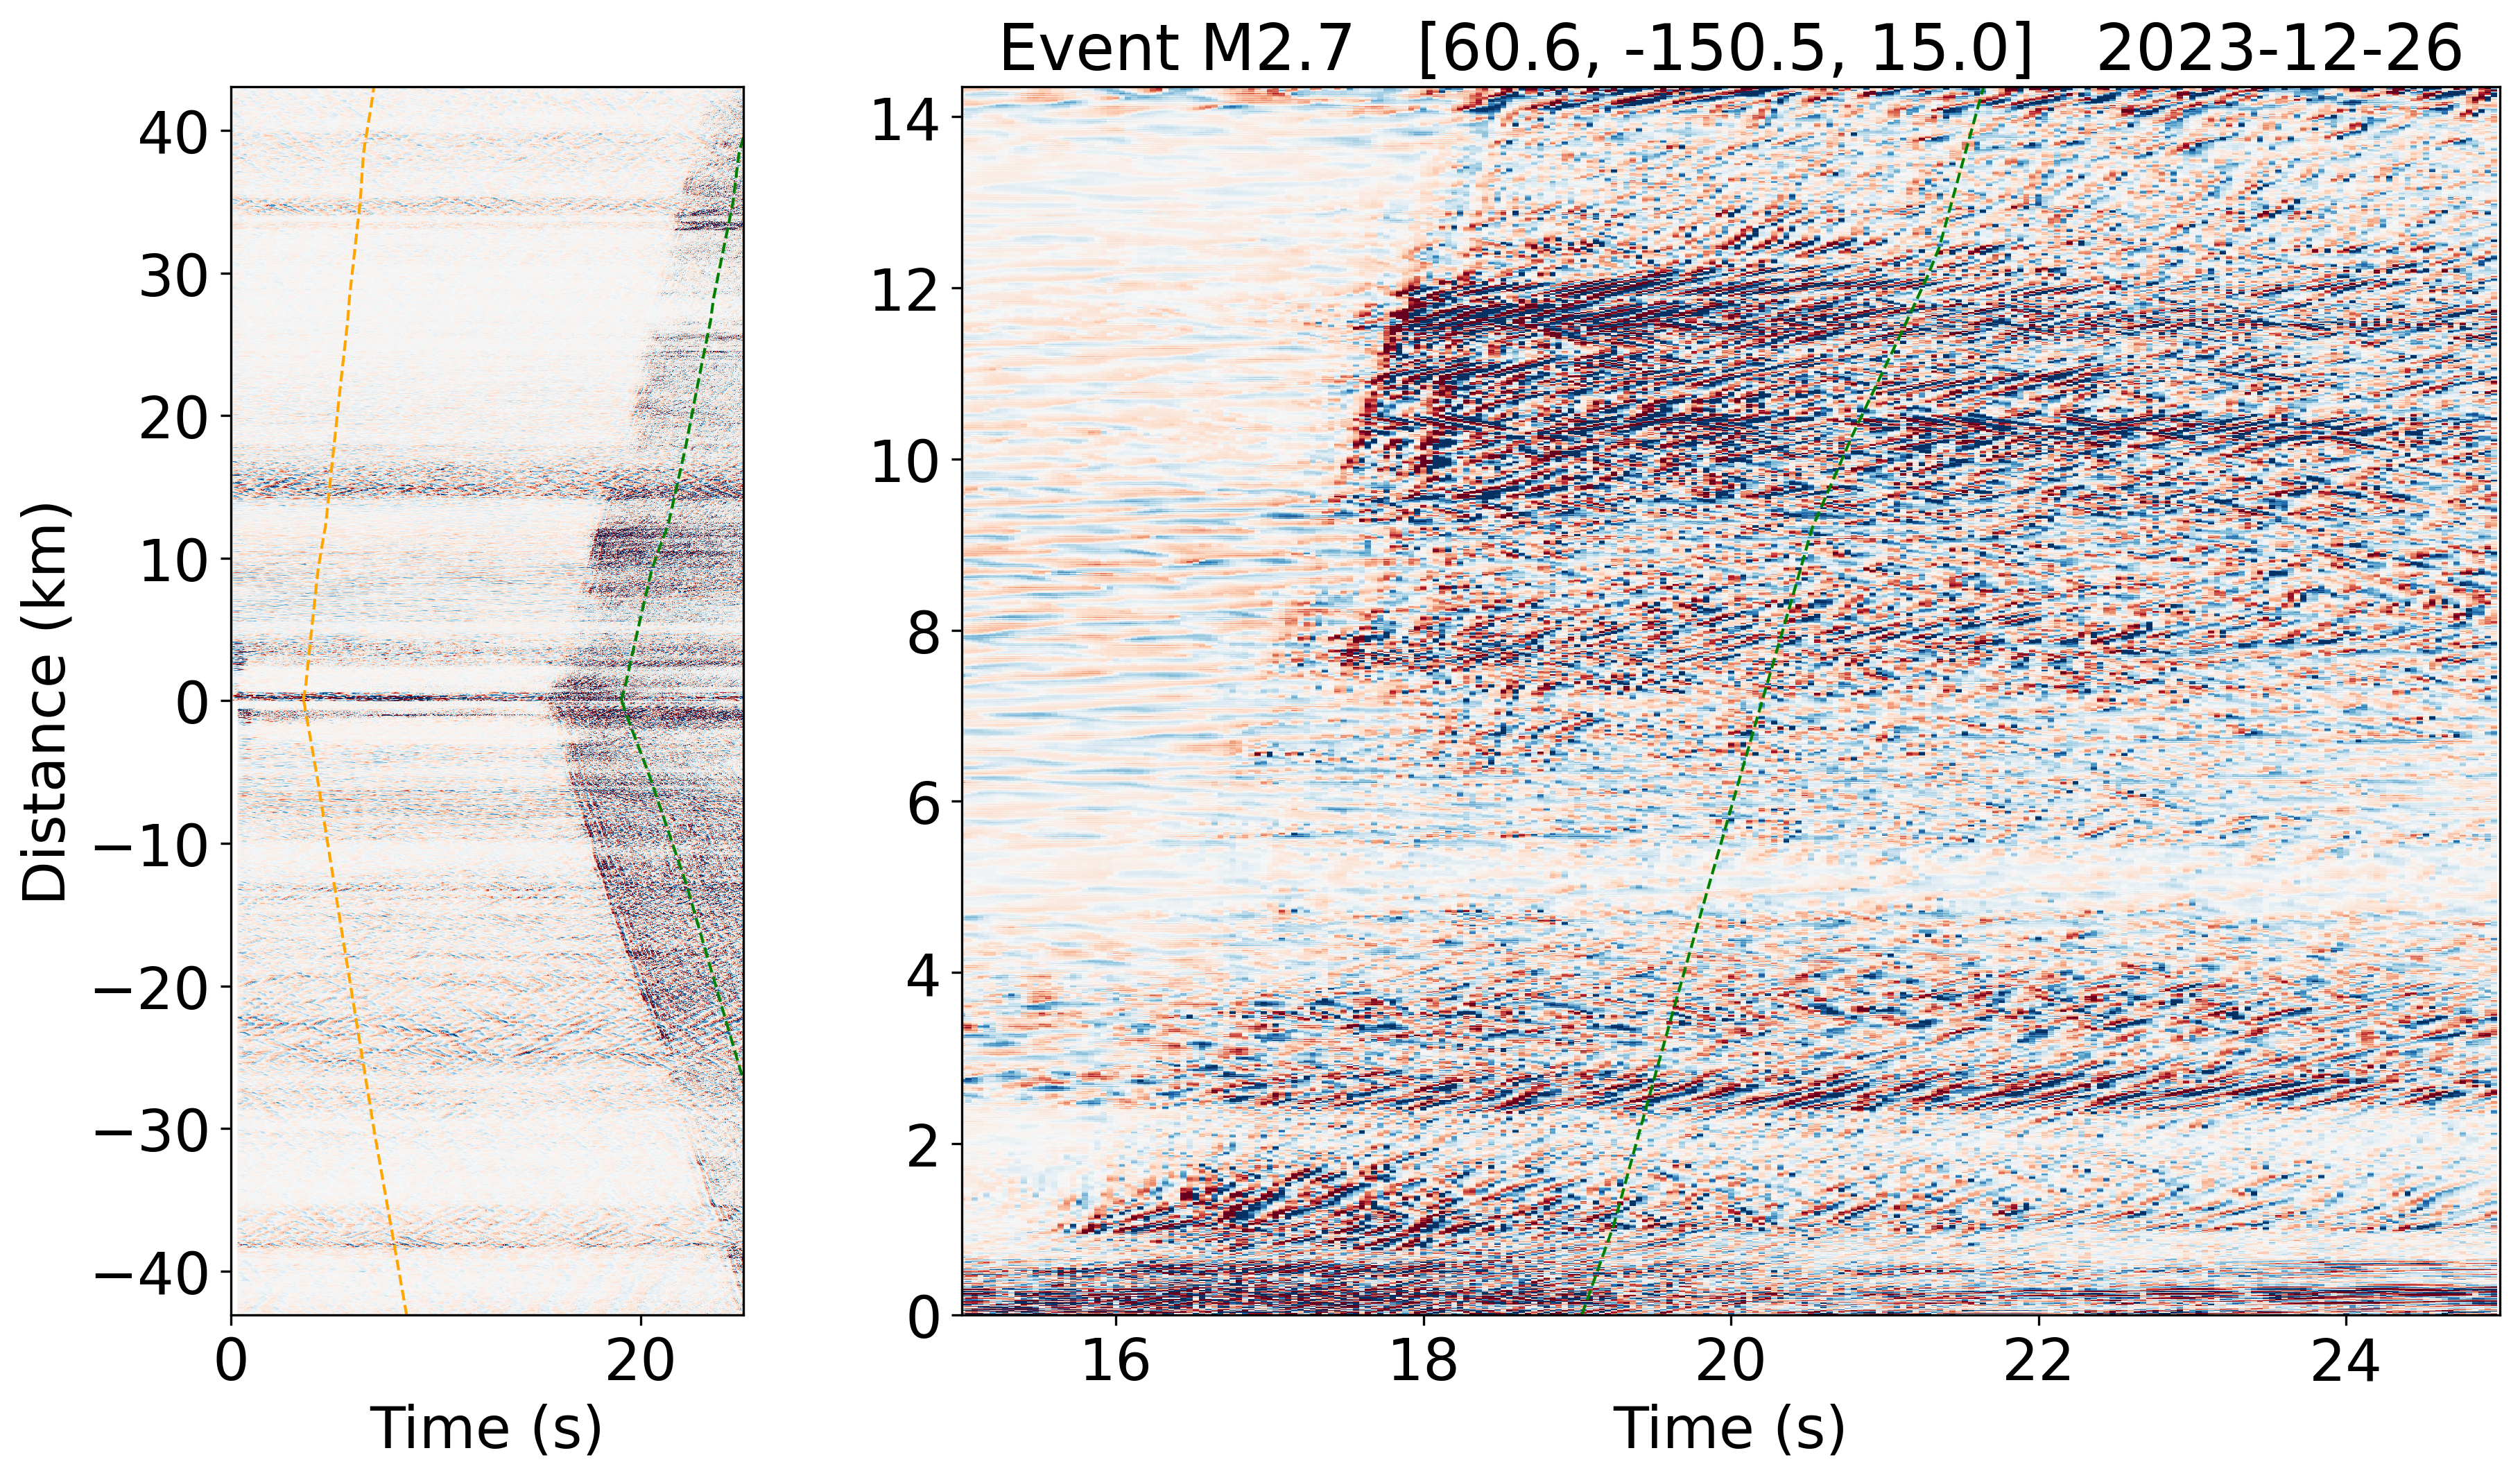

In [62]:
%matplotlib inline
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['font.size'] = 20
### predict phases for a given event in the catalog
event_number =11  ## for testing the best model
kkfls, terra, mag0,lon0,lat0,dep0,ort0 = akdas_tpts(cat, event_number, kkfls, terra, terra_early)

print("time is calculated")
### Shift for recording time
df = pd.read_csv(raw_dir + record_time_file).iloc[event_number]
start_times = df['record_time']
shift_time = cat[event_number].origins[0].time - UTCDateTime.strptime(start_times, format='decimator2_%Y-%m-%d_%H.%M.%S_UTC.h5') 
        

### plot
# time_data = rawdata[event_number]
time_data = mul_denoised[event_number]
# time_data = one_denoised[event_number]
time_data = time_data - np.mean(time_data, axis=1, keepdims=True)

print("plotting")
x = np.arange(time_data.shape[1])/sample_rate
y = np.arange(0-time_data.shape[0]/2, time_data.shape[0]/2)*dchan/1000
cmap=matplotlib.colormaps['RdBu']
bound = np.percentile(np.fabs(rawdata[event_number]), 90)/2

fig, ax = plt.subplots(1, 2, figsize=(12, 7), constrained_layout=True,
                gridspec_kw={'width_ratios': [1, 3], 'wspace': 0.1}, dpi=300)
plt.title(f'Event M{mag0}   [{lat0}, {lon0}, {dep0}]   {ort0}',fontsize=22)

### full array
print("fig1")
ax[0].pcolormesh(x+terra_early, y[:ch_max], time_data[:ch_max,:], shading='auto', vmin=-bound, vmax=bound, cmap=cmap, rasterized=True)
ax[0].pcolormesh(x, y[ch_max:], time_data[ch_max:,:], shading='auto', vmin=-bound, vmax=bound, cmap=cmap, rasterized=True)
ax[0].plot(kkfls['ts']+shift_time+terra_early, kkfls['dist']/1000, color='green', linestyle='--', lw=1)
ax[0].plot(kkfls['tp']+shift_time+terra_early, kkfls['dist']/1000, color='orange', linestyle='--', lw=1)
ax[0].plot(terra['ts']+shift_time, terra['dist']/1000, color='green', linestyle='--', lw=1)
ax[0].plot(terra['tp']+shift_time, terra['dist']/1000, color='orange', linestyle='--', lw=1)
ax[0].set_xlabel("Time (s)", fontsize=20); 
ax[0].set_ylabel("Distance (km)", fontsize=20)
ax[0].set_xlim(0, 25)

### sub array
print("fig2")
st_terra = 0
ch1=ch_max +st_terra
ch2=ch1 + 1500
y= y[ch1:ch2]
x= x[15*25:25*25]
time_data=time_data[ch1:ch2, 15*25:25*25]
# ax[0].plot([x[5],x[5],x[-5],x[-5],x[5]],
#         [y[0],y[-1],y[-1],y[0],y[0]], 
#         color='orange', linestyle='-', lw=5)

img=ax[1].pcolormesh(x, y, time_data, shading='auto', vmin=-bound, vmax=bound, cmap=cmap, rasterized=True)
ax[1].plot(terra['ts'].iloc[st_terra:st_terra+1500]+shift_time, terra['dist'].iloc[st_terra:st_terra+1500]/1000, color='green', linestyle='--', lw=1)
ax[1].plot(terra['tp'].iloc[st_terra:st_terra+1500]+shift_time, terra['dist'].iloc[st_terra:st_terra+1500]/1000, color='orange', linestyle='--', lw=1)
# cbr=plt.colorbar(img, aspect=50, ax=ax[1]); cbr.set_label('amplitude', fontsize = 20)
ax[1].set_xlabel("Time (s)", fontsize=20)
ax[1].set_xlim(15, 25)
print("fig done", bound)



In [ ]:
plt.savefig(out_dir + 'event_mul_test.pdf', format='pdf', dpi=300)

## 2. How Does The Denoiser Work?

It is classic U-net trained on our DAS recordings

In [8]:
""" Initialize the U-net model """
devc = try_gpu(i=1)

model_1 = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_1 = nn.DataParallel(model_1, device_ids=[1,2,3])
model_1.to(devc)

""" Load the pretrained weights """
model_1.load_state_dict(torch.load('../models/checkpoint_noatt_LRdecays0.8_mask0.5_raw2raw_chmax4500.pt'))  # raw2raw
# model_1.load_state_dict(torch.load('../models/checkpoint_noatt_LRdecays0.8_mask0.5_raw2fk_chmax4500.pt'))  # raw2fk
model_1.eval() 

DataParallel(
  (module): unet(
    (relu): ReLU()
    (layer): ModuleList(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): MaxBlurPool2d()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): MaxBlurPool2d()
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): MaxBlurPool2d()
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): Dropout(p=0.2, inplace=False)
      (12): MaxBlurPool2d()
      (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

Denoise a small sample DAS (you can skip this)

In [ ]:
# X=rawdata[:100,:,:].astype(np.float32)
X=rawdata[:,:,:].astype(np.float32)

X = torch.from_numpy(X).to(devc)
### denoise
with torch.no_grad():
    ### raw2raw
    oneDenoise_1 = model_1(X)
    mulDenoise_1 = model_1(oneDenoise_1)
    mulDenoise_1 = model_1(mulDenoise_1)
    mulDenoise_1 = model_1(mulDenoise_1)

### convert back to numpy, trim edges
rawdata_trim = X.to('cpu').numpy()
oneDenoise_1 = oneDenoise_1.to('cpu').numpy()
mulDenoise_1 = mulDenoise_1.to('cpu').numpy()

### Denoise many earthquakes

In [9]:
cat1 = cat[:]
inp_data = rawdata[:,:,:]
one_denoised = np.zeros_like(inp_data)
mul_denoised = np.zeros_like(inp_data)

for eid in np.arange(len(inp_data)):
    one_denoised[eid,:,:], mul_denoised[eid,:,:] = Denoise_largeDAS(inp_data[eid], 
                                                                    model_1, 
                                                                    devc, 
                                                                    repeat=4, 
                                                                    norm_batch=False)

%matplotlib inline
# vizRawDenoise(inp_data, one_denoised, mul_denoised, index=range(len(inp_data)), model="raw-raw")

### Plot FK for raw and denoised

In [50]:
from das_util import next_power_of_2, fk_filter_2cones
event_number =11 
st_terra = 0
ch1=ch_max +st_terra
ch2=ch1 + 4500

sub_rawdata = rawdata[event_number, ch1:ch2, 0*25:60*25]
sub_rawdata = sub_rawdata - np.mean(sub_rawdata, axis=1, keepdims=True)
sub_denoise = mul_denoised[event_number, ch1:ch2, 0*25:60*25]
sub_denoise = sub_denoise - np.mean(sub_denoise, axis=1, keepdims=True)

_, _, fk_rawdata = fk_filter_2cones(sub_rawdata.T, w1=0.003, w2=0.003, cone1=True, cone2=True)
_, _, fk_denoise = fk_filter_2cones(sub_denoise.T, w1=0.003, w2=0.003, cone1=True, cone2=True)

f0 = np.fft.fftshift(np.fft.fftfreq(next_power_of_2(1500),d=1./sample_rate))
k0 = np.fft.fftshift(np.fft.fftfreq(next_power_of_2(4500),d=dchan))
df = f0[1]-f0[0]
dk = k0[1]-k0[0]

In [81]:
%matplotlib agg
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['font.size'] = 20

amps = np.log10(np.abs(fk_denoise)).flatten()
q1=np.percentile(amps, q=20)
q2=np.percentile(amps, q=99)

plt.close('all')
fig, ax = plt.subplots(2, 1, figsize=(12, 9), constrained_layout=True)
ax[0].set_title(f'Event M{mag0}   [{lat0}, {lon0}, {dep0}]   {ort0}',fontsize=22)

im=ax[0].pcolormesh(k0, f0, np.log10(np.abs(fk_rawdata)), shading='auto', vmax=q2, vmin=q1, cmap=cmap.reversed(), rasterized=True)
plt.colorbar(im, ax=ax[0], aspect=50)


im=ax[1].pcolormesh(k0, f0, np.log10(np.abs(fk_denoise)), shading='auto', vmax=q2, vmin=q1, cmap=cmap.reversed(), rasterized=True)
plt.colorbar(im, ax=ax[1], aspect=50)

ax[0].set_ylabel("Frequency(Hz)", fontsize=20)
ax[1].set_xlabel("Wavenumber (1/m)", fontsize=20)
ax[1].set_ylabel("Frequency(Hz)", fontsize=20)
ax[1].set_xlim(-0.04, 0.04)
ax[0].set_xlim(-0.04, 0.04)


/tmp/ipykernel_2950981/2423696322.py:6: RuntimeWarning: divide by zero encountered in log10
  amps = np.log10(np.abs(fk_denoise)).flatten()


/tmp/ipykernel_2950981/2423696322.py:18: RuntimeWarning: divide by zero encountered in log10
  im=ax[1].pcolormesh(k0, f0, np.log10(np.abs(fk_denoise)), shading='auto', vmax=q2, vmin=q1, cmap=cmap.reversed(), rasterized=True)


(-0.04, 0.04)

In [82]:
plt.savefig(out_dir + 'event_fk.pdf', format='pdf', dpi=300)

In [83]:
### functions to calculate PDF of multiple channels
def ppsd(data,fs,fmin,fmax):
    """
    data:  2D array, the statistics is calculated along axis=0
    fs: sampling rate
    fmin: minimum frequency for statistics
    fmax: maximum frequency for statictics
    """
    ns = data.shape[1]
    nx = data.shape[0]
    
    ### Demean, detrend
    data -= np.mean(data, axis=1, keepdims=True) 
#     data = sgn.detrend(data, axis=1) 
    
    freq, spec = sgn.periodogram(data, sample_rate, window='hamming', axis=-1)
    freq = np.tile(freq,(nx,1)).flatten()

    ### Generate PDF
    xbins = np.logspace(np.log10(fmin),np.log10(fmax),60)
    ybins = np.logspace(np.log10(np.nanmin(spec)),np.log10(np.nanmax(spec)),90)
    
    H,xe,ye = np.histogram2d(freq.flatten(), spec.flatten(), bins=(xbins,ybins))
    
    return H/np.nansum(H, axis=1, keepdims=True), (xe[1:] + xe[:-1])/2, (ye[1:] + ye[:-1])/2
    
def psd_stats(H,xm,ym):
    ym = np.log10(ym)
    mean = np.zeros(len(xm))
    variance = mean.copy()
    for ix in range(len(xm)):
        mean[ix] = np.average(ym,weights=H[ix,:])
        variance[ix] = np.average((ym-mean[ix])**2,weights=H[ix,:])
    
    return xm,10**mean,variance

In [112]:
%matplotlib agg
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['font.size'] = 20

plt.close('all')
fig,ax = plt.subplots(1,2,figsize=(25,12))

colors = matplotlib.colormaps['Blues'](np.linspace(0.2, 1, 5))

for i, chan in tqdm(enumerate([5000, 6000, 7000, 8000, 9000])):

    
    ### Correct raw data to strain
    trs_raw = rawdata[1,chan-500:chan,250:750].astype(float) * (1550 * 1e-9) / (0.78 * 4 * np.pi * 1.4682 * 23.9)
    trs_den = mul_denoised[1,chan-500:chan,250:750].astype(float) * (1550 * 1e-9) / (0.78 * 4 * np.pi * 1.4682 * 23.9)
    
    H,xm,ym = ppsd(trs_raw,sample_rate,0.015,12)
    xm,mn,vr = psd_stats(H,xm,ym)
    ax[0].plot(1/xm, mn,linewidth=5, label='%.1f km' % ((chan-4500-250)*dchan*1e-3), zorder=2, color=colors[int(abs(i))])

    # if i == 0:
    #     img=ax[0].pcolormesh(1/xm,ym,H.T,cmap='hot_r',vmin=0,vmax=0.2, zorder=1)

    H,xm,ym = ppsd(trs_den,sample_rate,0.015,12)
    xm,mn,vr = psd_stats(H,xm,ym)
    ax[1].plot(1/xm, mn,linewidth=5, label='%.1f km' % ((chan-4500-250)*dchan*1e-3), zorder=2, color=colors[int(abs(i))])
    
    # if i == 0:
    #     img=ax[1].pcolormesh(1/xm,ym,H.T,cmap='hot_r',vmin=0,vmax=0.2, zorder=1)

    if i > 2:
        
        ## noise window
        trs = rawdata[1,chan-500:chan,:500].astype(float) * (1550 * 1e-9) / (0.78 * 4 * np.pi * 1.4682 * 23.9)
        
        H,xm,ym = ppsd(trs,sample_rate,0.015,12)
        xm,mn,vr = psd_stats(H,xm,ym)
        plt.plot(1/xm,mn,'k',linewidth=5, zorder=2, linestyle='dotted', color=colors[i])

            

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(1/12.5, 4)
ax[0].set_ylim(1e-21,1e-16) 
ax[1].set_xscale('log')
ax[1].set_yscale('log')   
ax[1].set_xlim(1/12.5, 4)
ax[1].set_ylim(1e-21,1e-16)
ax[0].set_xlabel('Period (s)')
ax[0].set_ylabel('PSD rel. strain ^2')
ax[1].set_xlabel('Period (s)')
ax[1].set_ylabel('PSD rel. strain ^2')

ax[0].grid(which='major', color='#DDDDDD', linewidth=3, zorder=0)
ax[0].grid(which='minor', color='#EEEEEE', linewidth=2, linestyle='--', zorder=0)
ax[1].grid(which='major', color='#DDDDDD', linewidth=3, zorder=0)
ax[1].grid(which='minor', color='#EEEEEE', linewidth=2, linestyle='--', zorder=0)
plt.legend()
# plt.tight_layout()

0it [00:00, ?it/s]/tmp/ipykernel_2950981/1964896783.py:25: RuntimeWarning: invalid value encountered in divide
  return H/np.nansum(H, axis=1, keepdims=True), (xe[1:] + xe[:-1])/2, (ye[1:] + ye[:-1])/2
/tmp/ipykernel_2950981/3248505814.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(1/xm,mn,'k',linewidth=5, zorder=2, linestyle='dotted', color=colors[i])
5it [00:00, 37.56it/s]


In [113]:
plt.savefig(out_dir + 'event_spec.pdf', format='pdf', dpi=300)

In [ ]:
def vizRawDenoise_lite(in_data, oneDenoise, mulDenoise, sample_rate=25, dchan=10, index=[0,1], model="MAE"):
    """
    in_data, oneDenoise, mulDenoise: 3D -- [event, channel, time]
    index: list, subset of the events
    model: string, descriptions about the model
    """
    len1, len2 = oneDenoise[0].shape[0], oneDenoise[0].shape[1]
    x, y = np.arange(len2)/sample_rate, np.arange(0-len1/2, len1/2)*dchan/1000
    rawdata = process_3d_array(in_data, len1=len1, len2=len2)
    
    matplotlib.rcParams['font.size'] = 20

    for j in index:
        bound = np.percentile(np.fabs(in_data[j]), 80)
        cmp = matplotlib.colormaps['RdBu']
        fig, ax = plt.subplots(1, 2, figsize=(12, 3.5), constrained_layout=True)

        img=ax[0].pcolormesh(x, y, rawdata[j], shading='auto', vmin=-bound, vmax=bound, cmap=cmap, rasterized=True)
        ax[1].pcolormesh(x, y, mulDenoise[j], shading='auto', vmin=-bound, vmax=bound, cmap=cmap)
        ax[0].set_title("Raw data #"+str(j))
        ax[1].set_title(model+" Denoised")
        ax[0].set_ylabel('Distance (km)')
        ax[0].set_xlabel('Time (s)')
        ax[1].set_xlabel('Time (s)')

        plt.colorbar(img, ax=ax[1], aspect=20)
        plt.savefig(out_dir + 'event'+ str(model)+'PandS.pdf', format='pdf', dpi=300)

%matplotlib agg
vizRawDenoise_lite(inp_data[:,3600:3900,:], one_denoised[:,3600:3900,:], mul_denoised[:,3600:3900,:], index=[18], model="1")
vizRawDenoise_lite(inp_data[:,0:300,:], one_denoised[:,0:300,:], mul_denoised[:,0:300,:], index=[21], model="2")
vizRawDenoise_lite(inp_data[:,3000:3300,:], one_denoised[:,3000:3300,:], mul_denoised[:,3000:3300,:], index=[21], model="3")
vizRawDenoise_lite(inp_data[:,3500:3800,:], one_denoised[:,3500:3800,:], mul_denoised[:,3500:3800,:], index=[21], model="4")
vizRawDenoise_lite(inp_data[:,3800:4100,:], one_denoised[:,3800:4100,:], mul_denoised[:,3800:4100,:], index=[34], model="5")
vizRawDenoise_lite(inp_data[:,900:1200,:], one_denoised[:,900:1200,:], mul_denoised[:,900:1200,:], index=[43], model="6")
vizRawDenoise_lite(inp_data[:,7000:7300,:], one_denoised[:,7000:7300,:], mul_denoised[:,7000:7300,:], index=[43], model="7")

### Save as H5

In [ ]:
### Save denoised data
with h5py.File(out_dir + 'das_raw_denoised.hdf5', 'w') as f:
    f.create_dataset("input_data", data=inp_data)
    f.create_dataset("one_denoise", data=one_denoised)
    f.create_dataset("mul_denoise", data=mul_denoised)
cat1.write(out_dir + "denoised_catalog.xml", format="QUAKEML")

In [ ]:
vizRawDenoise(inp_data, one_denoised, mul_denoised, index=range(10), model="raw-raw")

## 3. Pick Phases

### Interpolate DAS data

The phase picker needs 6000 time points as input

In [ ]:
### Read raw and denoised DAS
with h5py.File(out_dir + 'das_raw_denoised.hdf5', 'r') as f:
    inp_data = f["input_data"][:]
    one_denoised = f["one_denoise"][:]
    mul_denoised = f["mul_denoise"][:]

cat1 = read_events(out_dir + "denoised_catalog.xml")

### interpolate
interp_func = interp1d(np.linspace(0, 1, 1500), inp_data, axis=-1, kind='linear')
interpolated_image = interp_func(np.linspace(0, 1, 6000))
interp_func = interp1d(np.linspace(0, 1, 1500), one_denoised, axis=-1, kind='linear')
interpolated_onedenoised = interp_func(np.linspace(0, 1, 6000))
interp_func = interp1d(np.linspace(0, 1, 1500), mul_denoised, axis=-1, kind='linear')
interpolated_muldenoised = interp_func(np.linspace(0, 1, 6000))

### Set up phase picker
Emsemble-learning framework for picking (Yuan et al, 2023)

In [ ]:
### ML picker parameters
paras_semblance = {'dt':0.01, 
                   'semblance_order':2, 
                   'window_flag':True, 
                   'semblance_win':0.5, 
                   'weight_flag':'max'}

### Download models
devcc = try_gpu(i=1)

pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")

pn_ethz_model.to(devcc)
pn_scedc_model.to(devcc)
pn_neic_model.to(devcc)
pn_geofon_model.to(devcc)
pn_stead_model.to(devcc)
pn_instance_model.to(devcc)

list_models = [pn_ethz_model,pn_scedc_model,pn_neic_model,
               pn_geofon_model,pn_stead_model,pn_instance_model]

### Pick many earthquaks

In [ ]:
Nevent=len(inp_data)

fs=100
ch_itv=2  # data are downsampled to pick
dchan=9.5714

nsta = interpolated_image.shape[1] // ch_itv
raw_picks = np.zeros([Nevent, nsta, 2, 2], dtype = np.float32)
one_picks = np.zeros([Nevent, nsta, 2, 2], dtype = np.float32)
mul_picks = np.zeros([Nevent, nsta, 2, 2], dtype = np.float32)
pred_picks = np.zeros([Nevent, nsta, 2], dtype = np.float32)

for i in tqdm(np.arange(Nevent)):
    
    ### Predict arrivals
    fiber1, fiber2, _,_,_,_,_ = akdas_tpts(cat1, i, kkfls, terra, terra_early)
    array = pd.concat([fiber1.iloc[::-1], fiber2], axis=0)
    pred_picks[i, :, 0] = array['tp'].values[::ch_itv]
    pred_picks[i, :, 1] = array['ts'].values[::ch_itv]
    array_dist = array['dist']/1000
    
    ### Pick RAW data
    image = np.nan_to_num(interpolated_image[i,::ch_itv,:])
    raw_picks[i,:,:,:] = apply_elep(image, list_models, fs, paras_semblance, devcc)
    
    ### Pick oneDENOISED  
    image =np.nan_to_num(interpolated_onedenoised[i,::ch_itv,:])
    one_picks[i,:,:,:] = apply_elep(image, list_models, fs, paras_semblance, devcc)
    
    ### Pick mulDENOISED 
    image = np.nan_to_num(interpolated_muldenoised[i,::ch_itv,:])
    mul_picks[i,:,:,:] = apply_elep(image, list_models, fs, paras_semblance, devcc)

### Save results to H5

In [ ]:
with h5py.File(out_dir + 'phase_picks.hdf5', 'w') as f:
    f.create_dataset("raw_alldata_picks", data=raw_picks)
    f.create_dataset("one_denoise_picks", data=one_picks)
    f.create_dataset("mul_denoise_picks", data=mul_picks)
    f.create_dataset("predicted_picks", data=pred_picks)
    f.create_dataset("array_dist", data=array_dist)

## 4. Quality Control and Visualization 
These cells below can be run independently.

In [ ]:
### Read phase picks from the previous session
with h5py.File(out_dir + 'phase_picks_400_555.hdf5', 'r') as f:
    raw_picks = f["raw_alldata_picks"][:]
    one_picks = f["one_denoise_picks"][:]
    mul_picks = f["mul_denoise_picks"][:]
    pred_picks = f["predicted_picks"][:]
    array_dist = f["array_dist"][:]
    
### Read raw and denoised DAS
with h5py.File(out_dir + 'das_raw_denoised_400_555.hdf5', 'r') as f:
    inp_data = f["input_data"][:]
    one_denoised = f["one_denoise"][:]
    mul_denoised = f["mul_denoise"][:]

### Read the catalog
cat1 = read_events(out_dir + "denoised_catalog_400_555.xml")

### Recording time
df = pd.read_csv(raw_dir + record_time_file).iloc[200:400]
start_times = df['record_time'].values
org_times = [evt.origins[0].time - UTCDateTime.strptime(start_t, format='decimator2_%Y-%m-%d_%H.%M.%S_UTC.h5') for evt, start_t in zip(cat1 , start_times)]
pred_picks += np.array(org_times)[:, np.newaxis, np.newaxis]

### interpolate
interp_func = interp1d(np.linspace(0, 1, 1500), inp_data, axis=-1, kind='linear')
interpolated_image = interp_func(np.linspace(0, 1, 6000))
interp_func = interp1d(np.linspace(0, 1, 1500), one_denoised, axis=-1, kind='linear')
interpolated_onedenoised = interp_func(np.linspace(0, 1, 6000))
interp_func = interp1d(np.linspace(0, 1, 1500), mul_denoised, axis=-1, kind='linear')
interpolated_muldenoised = interp_func(np.linspace(0, 1, 6000))

QC the picks and plot

In [ ]:
Nevent=len(inp_data)
thr=0.05
fs=100
ch_itv=2  # data are downsampled to pick
dchan=9.5714
st, ed = 5, 55
tax=np.arange(interpolated_image.shape[2])/fs
win=np.where(np.logical_and(tax>st,tax<ed))[0]

snr_raw = np.zeros((Nevent, 2), dtype = np.float32)
snr_one = np.zeros((Nevent, 2), dtype = np.float32)
snr_mul = np.zeros((Nevent, 2), dtype = np.float32)
npk_raw = np.zeros((Nevent, 2), dtype = np.float32)
npk_one = np.zeros((Nevent, 2), dtype = np.float32)
npk_mul = np.zeros((Nevent, 2), dtype = np.float32)
std_raw = np.zeros((Nevent, 2), dtype = np.float32)
std_one = np.zeros((Nevent, 2), dtype = np.float32)
std_mul = np.zeros((Nevent, 2), dtype = np.float32)

for i in tqdm(np.arange(Nevent)):
    evt = cat1[i]
    mag = evt.magnitudes[0].mag
    lon = evt.origins[0].longitude
    lat = evt.origins[0].latitude
    dep = evt.origins[0].depth/1000  ## too shallow depth+ long distance = bugs
    ort = evt.origins[0].time
    
    mag0, lon0, lat0, dep0, ort0= \
    round(mag,1), round(lon,2), round(lat,2), round(dep,0), ort.strftime('%Y-%m-%d')

    plt.figure(figsize=(24, 8), constrained_layout=True)

    ### Raw data
    image = np.nan_to_num(interpolated_image[i,::ch_itv,:])
    offset_s, std_raw[i,1], mean_offset_s, ind_s = fit_series(
        raw_picks[i,:,1,0], pred_picks[i,:,1], raw_picks[i,:,1,1], thr=0.05, vmin=st, vmax=ed)
    
    offset_p, std_raw[i,0], mean_offset_p, ind_p = fit_series(
        raw_picks[i,:,0,0], pred_picks[i,:,0], raw_picks[i,:,0,1], thr=0.1, vmin=st, vmax=ed)
    
    plt.subplot(2, 6, 1) 
    subfig_img(image, raw_picks[i], ind_p, ind_s, pred_picks[i], array_dist[::ch_itv],
               "M"+str(mag0)+" lat. "+str(lat0)+" lon. "+str(lon0))
        
    plt.subplot(2, 6, 2) 
    subfig_histpick(raw_picks[i])
    
    plt.subplot(2, 6, 7) 
    snr_raw[i,0], snr_raw[i,1] = subfig_goodtrace(
        image, raw_picks[i], ind_p, ind_s, tax, win)
    npk_raw[i,0], npk_raw[i,1] = len(ind_p), len(ind_s)
            
    plt.subplot(2, 6, 8)
    plt.hist(offset_p,bins=20,edgecolor='b',fill=False,label='p',range=(-1,1))
    plt.hist(offset_s,bins=20,edgecolor='g',fill=False,label='s',range=(-1,1))
    plt.title(str(npk_raw[i,0])+"p|"+str(npk_raw[i,1])+"s|"+
              "SNR "+str(round(snr_raw[i,0],1))+"/"+str(round(snr_raw[i,1],1)))
    
    ### oneDENOISED  
    image = np.nan_to_num(interpolated_onedenoised[i,::ch_itv,:])
    offset_s, std_one[i,1], mean_offset_s, ind_s= fit_series(
        one_picks[i,:,1,0], pred_picks[i,:,1], one_picks[i,:,1,1], thr=0.05, vmin=st, vmax=ed)
    
    offset_p, std_one[i,0], mean_offset_p, ind_p= fit_series(
        one_picks[i,:,0,0], pred_picks[i,:,0], one_picks[i,:,0,1], thr=0.1, vmin=st, vmax=ed)
    
    plt.subplot(2, 6, 3) 
    subfig_img(image, one_picks[i], ind_p, ind_s, pred_picks[i], array_dist[::ch_itv], 
                "Ensemble Picking on Denoised data")
    
    plt.subplot(2, 6, 4) 
    subfig_histpick(one_picks[i])
    
    plt.subplot(2, 6, 9) 
    snr_one[i,0], snr_one[i,1]=subfig_goodtrace(
        image, one_picks[i], ind_p, ind_s, tax, win)
    npk_one[i,0], npk_one[i,1] = len(ind_p), len(ind_s)
    
    plt.subplot(2, 6, 10) 
    plt.hist(offset_p,bins=20,edgecolor='b',fill=False,label='p',range=(-1,1))
    plt.hist(offset_s,bins=20,edgecolor='g',fill=False,label='s',range=(-1,1))
    plt.title(str(npk_one[i,0])+"p|"+str(npk_one[i,1])+"s|"+
              "SNR "+str(round(snr_one[i,0],1))+"/"+str(round(snr_one[i,1],1)))
    
    ### mulDENOISED 
    image = np.nan_to_num(interpolated_muldenoised[i,::ch_itv,:])
    offset_s, std_mul[i,1], mean_offset_s, ind_s= fit_series(
        mul_picks[i,:,1,0], pred_picks[i,:,1], mul_picks[i,:,1,1], thr=0.05, vmin=st, vmax=ed)
    
    offset_p, std_mul[i,0], mean_offset_p, ind_p= fit_series(
        mul_picks[i,:,0,0], pred_picks[i,:,0], mul_picks[i,:,0,1], thr=0.1, vmin=st, vmax=ed)
    
    plt.subplot(2, 6, 5) 
    subfig_img(image, mul_picks[i], ind_p, ind_s, pred_picks[i], array_dist[::ch_itv], 
               "Ensemble Picking on Denoised data")
    
    plt.subplot(2, 6, 6) 
    subfig_histpick(mul_picks[i])
    
    plt.subplot(2, 6, 11) 
    snr_mul[i,0], snr_mul[i,1]= subfig_goodtrace(
        image, mul_picks[i], ind_p, ind_s, tax, win)
    npk_mul[i,0], npk_mul[i,1]  = len(ind_p), len(ind_s)
    
    plt.subplot(2, 6, 12) 
    plt.hist(offset_p,bins=20,edgecolor='b',fill=False,label='p',range=(-1,1))
    plt.hist(offset_s,bins=20,edgecolor='g',fill=False,label='s',range=(-1,1))
    plt.title(str(npk_mul[i,0])+"p|"+str(npk_mul[i,1])+"s|"+
              "SNR "+str(round(snr_mul[i,0],1))+"/"+str(round(snr_mul[i,1],1)))

            
    plt.savefig(f"{out_dir}picks_event_{i+400}_thr010p005s.png")
    plt.close()

In [ ]:
with h5py.File(out_dir + 'pick_stats_400_555_thr010p005s.hdf5', 'w') as f:
    f.create_dataset("raw_alldata_picks", data=raw_picks)
    f.create_dataset("one_denoise_picks", data=one_picks)
    f.create_dataset("mul_denoise_picks", data=mul_picks)
    f.create_dataset("predicted_picks", data=pred_picks)
    f.create_dataset("array_dist", data=array_dist)
    f.create_dataset("raw_alldata_snr", data=snr_raw)
    f.create_dataset("one_denoise_snr", data=snr_one)
    f.create_dataset("mul_denoise_snr", data=snr_mul)
    f.create_dataset("raw_alldata_numpick", data=npk_raw)
    f.create_dataset("one_denoise_numpick", data=npk_one)
    f.create_dataset("mul_denoise_numpick", data=npk_mul)
    f.create_dataset("raw_alldata_pickerr", data=std_raw)
    f.create_dataset("one_denoise_pickerr", data=std_one)
    f.create_dataset("mul_denoise_pickerr", data=std_mul)

## 5. Wiggle anaysis

In [ ]:
### Read phase picks from the previous session
with h5py.File(out_dir + 'phase_picks.hdf5', 'r') as f:
    raw_picks = f["raw_alldata_picks"][:]
    one_picks = f["one_denoise_picks"][:]
    mul_picks = f["mul_denoise_picks"][:]
    pred_picks = f["predicted_picks"][:]
    array_dist = f["array_dist"][:]
    
### Read raw and denoised DAS
with h5py.File(out_dir + 'das_raw_denoised.hdf5', 'r') as f:
    inp_data = f["input_data"][:]
    one_denoised = f["one_denoise"][:]
    mul_denoised = f["mul_denoise"][:]

### Read the catalog
cat1 = read_events(out_dir + "denoised_catalog.xml")

### Recording time
df = pd.read_csv(raw_dir + record_time_file)
start_times = df['record_time'].values
org_times = [evt.origins[0].time - UTCDateTime.strptime(start_t, format='decimator2_%Y-%m-%d_%H.%M.%S_UTC.h5') for evt, start_t in zip(cat1 , start_times)]
pred_picks += np.array(org_times)[:, np.newaxis, np.newaxis]

### interpolate
# interp_func = interp1d(np.linspace(0, 1, 1500), inp_data, axis=-1, kind='linear')
# interpolated_image = interp_func(np.linspace(0, 1, 6000))
# interp_func = interp1d(np.linspace(0, 1, 1500), one_denoised, axis=-1, kind='linear')
# interpolated_onedenoised = interp_func(np.linspace(0, 1, 6000))
# interp_func = interp1d(np.linspace(0, 1, 1500), mul_denoised, axis=-1, kind='linear')
# interpolated_muldenoised = interp_func(np.linspace(0, 1, 6000))

In [ ]:
pred_picks.shape, raw_picks.shape, one_picks.shape, mul_picks.shape
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['font.size'] = 20

In [ ]:
%matplotlib agg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['font.size'] = 20
    
maxshift =1
cc_thres =0.25
######################################################
def plot_record(ind, image, picks, fs, tax, t_bef=2, t_aft=3, integrate=False):

    wave = np.zeros((len(ind), int((t_bef+t_aft)*fs)), dtype = np.float32)
        
    for j, ch in enumerate(ind): 
        pt = int(picks[ch]*fs)
        trace = image[ch, pt- t_bef*fs:pt+ t_aft*fs]
        if integrate:
            int1 = cumulative_trapezoid(trace, tax, initial=0)
            wave[j] = (int1-np.mean(int1))
        else:
            wave[j] = trace * 20

    alighed_wave, shifts, cccs = align_channels_twice(wave, ref_ch=0, maxshift=int(maxshift*fs), cc_thres=cc_thres)

    if len(alighed_wave)>0:
        y = np.arange(alighed_wave.shape[0])
        bound = np.percentile(np.fabs(alighed_wave), 80)
        plt.pcolormesh(tax,y,alighed_wave, shading='auto',vmin=-bound,vmax=bound,cmap=matplotlib.colormaps['RdBu']) 
        
    stack = np.mean(alighed_wave[cccs>cc_thres,:], axis=0)
    
    ### plot the stacked trace
    plt.plot(tax, stack/np.std(stack)*len(ind)/20, color='g', linestyle='-', lw=2)
    plt.xlim(0-t_bef, t_aft)

    return shifts, cccs
######################################################

ch_itv=2  # data are downsampled to pick, so also downsampled to visualize
dchan=9.5714
fs=25
st, ed = 5, 55
tax=np.arange(0-2*fs,3*fs)/fs

offsets_raw = []
offsets_mul = []
offsets_mul_noalign = []
offsets_raw_noalign = []
cccs_raw = []
cccs_mul = []

### Choose several events from the catalog
for i in tqdm(range(0,95)):
    evt = cat1[i]
    mag = evt.magnitudes[0].mag
    lon = evt.origins[0].longitude
    lat = evt.origins[0].latitude
    dep = evt.origins[0].depth/1000
    ort = evt.origins[0].time

    mag0, lon0, lat0, dep0, ort0= \
    round(mag,1), round(lon,2), round(lat,2), round(dep,0), ort.strftime('%Y-%m-%d')
                  
    plt.figure(figsize=(25, 7.5), constrained_layout=True)
    gs = gridspec.GridSpec(2, 5, width_ratios=[1, 2, 2, 1, 1])

    ## mul denoised
    image = np.nan_to_num(mul_denoised[i,::ch_itv,:])

    offset_s, std_raw_s, mean_offset_s, ind_s = fit_series(
        mul_picks[i,:,1,0], pred_picks[i,:,1], mul_picks[i,:,1,1], thr=0.05, vmin=st, vmax=ed)
    
    if len(ind_s)==0:
        continue

    # plt.subplot(gs[1, 0])
    # subfig_img(image, mul_picks[i], ind_p, ind_s, pred_picks[i], array_dist[::ch_itv])
    # plt.title("Denoised")
    # plt.xlabel("Record time (s)")

    plt.subplot(gs[1, 1])
    shifts1, cccs1 = plot_record(ind_s[ind_s<2250], image, mul_picks[i,:,1,0], fs, tax)
    plt.xlabel("Time relative to S arrival (s)")
    
    plt.subplot(gs[1, 2])
    shifts2, cccs2 = plot_record(ind_s[ind_s>=2250], image, mul_picks[i,:,1,0], fs, tax)
    plt.xlabel("Time relative to S arrival (s)")

    # plt.subplot(gs[1, 3])
    cccs = np.concatenate((cccs1, cccs2),axis=None)
    # plt.hist(cccs, bins=20,edgecolor='k',fill=False)
    # plt.xlim(0,1)
    # plt.title('Cross-correlation coefficients')

    # plt.subplot(gs[1, 4])
    shifts = np.concatenate((shifts1, shifts2),axis=None)/fs
    # plt.hist(shifts,bins=20,edgecolor='k',fill=False)
    # plt.xlim(-1,1)
    # plt.title('Time shifts')

    offsets_mul.append(mul_picks[i,ind_s,1,0] + shifts - pred_picks[i,ind_s,1])
    offsets_mul_noalign.append(mul_picks[i,ind_s,1,0] - pred_picks[i,ind_s,1])
    cccs_mul.append(cccs)

    
    ### Raw data
    image = np.nan_to_num(inp_data[i,::ch_itv,:])

    offset_s, std_raw_s, mean_offset_s, ind_s = fit_series(
        raw_picks[i,:,1,0], pred_picks[i,:,1], raw_picks[i,:,1,1], thr=0.05, vmin=st, vmax=ed)

    # plt.subplot(gs[0, 0]) 
    # subfig_img(image, raw_picks[i], ind_p, ind_s, pred_picks[i], array_dist[::ch_itv])
    # plt.title("M"+str(mag0)+" lat. "+str(lat0)+" lon. "+str(lon0))
            
    plt.subplot(gs[0, 1])
    shifts1, cccs1 = plot_record(ind_s[ind_s<2250], image, raw_picks[i,:,1,0], fs, tax, integrate=False)
    plt.title("KKFL-S cable")
    
    plt.subplot(gs[0, 2])
    shifts2, cccs2 = plot_record(ind_s[ind_s>=2250], image, raw_picks[i,:,1,0], fs, tax, integrate=False)
    plt.title("TERRA cable")

    # plt.subplot(gs[0, 3])
    cccs = np.concatenate((cccs1, cccs2),axis=None)
    # plt.hist(cccs, bins=20, edgecolor='k', fill=False)
    # plt.xlim(0,1)
    # plt.title('Cross-correlation coefficients')

    # plt.subplot(gs[0, 4])
    shifts = np.concatenate((shifts1, shifts2),axis=None)/fs
    # plt.hist(shifts,bins=20,edgecolor='k',fill=False)
    # plt.title('Time shifts')
    # plt.xlim(-1,1)

    offsets_raw.append(raw_picks[i,ind_s,1,0] + shifts - pred_picks[i,ind_s,1])
    offsets_raw_noalign.append(raw_picks[i,ind_s,1,0] - pred_picks[i,ind_s,1])
    cccs_raw.append(cccs)

    plt.savefig(f"{out_dir}align_event_{i}.pdf")


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['font.size'] = 20
mul_pick_offsets = np.concatenate(offsets_mul_noalign, axis=None)
mul_align_offsets = np.concatenate(offsets_mul, axis=None)
cccs_mul = np.concatenate(cccs_mul, axis=None)
cccs_raw = np.concatenate(cccs_raw, axis=None)

# Create a figure
plt.figure(figsize=(7.5, 7.5), constrained_layout=True)

# Plot the S time error histogram
plt.hist(mul_pick_offsets, bins=300, alpha=0.5, color='gray', label='Picked S time - prediction')
plt.axvline(np.percentile(mul_pick_offsets,2.5), color='gray', linestyle='--', label='95% confidence')
plt.axvline(np.percentile(mul_pick_offsets,97.5), color='gray', linestyle='--')

plt.hist(mul_align_offsets, bins=300, alpha=0.5, color='b', label='Aligned S time - prediction')
plt.axvline(np.percentile(mul_align_offsets,2.5), color='b', linestyle='--', label='95% confidence')
plt.axvline(np.percentile(mul_align_offsets,97.5), color='b', linestyle='--')

plt.xlabel('Offsets')
plt.ylabel('Counts')
plt.legend()
plt.title('S Time Error Histogram')

# Create a figure
plt.figure(figsize=(7.5, 7.5), constrained_layout=True)
plt.hist(cccs_raw, bins=300, alpha=0.5, color='gray', label='Raw CC')
plt.hist(cccs_mul, bins=300, alpha=0.5, color='b', label='Denoised CC')
plt.legend()
plt.xlabel('CC between traces')
plt.ylabel('Counts')
plt.title('CC improvement')
plt.savefig(f"{out_dir}align_cc.pdf")


In [ ]:
np.min(mul_pick_offsets)